### Check the correct Python environment

In [1]:
import sys
print(sys.executable)

C:\Users\GZLI\AppData\Local\Programs\Python\Python38\python.exe


### Package Importing

In [2]:
from os import listdir
import random
from pathlib import Path
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords

import spacy
from spacy import displacy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Input
from keras.layers import concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

C:\Users\GZLI\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nlp = spacy.load('en_core_web_sm')

### Train the Spacy Entity Recognizer Model for more entities 
Annotation of Custom Entity

In [4]:
# Helper Function

# text = 'My son is in depression because of his grades'
# look = 'depression'
# if text.find(look) != -1:    
#     start = text.find(look)
#     end = text.find(look)+len(look)

# print(start, end, text[start:end])

# I have the flu
# I got a fever
# He was identified as diabetic positive after the blood test
# My daughter is having severe toothache 
# Heart disease is what I was afraid of and eventually got that
# My son is in depression because of his grades

**Train and Save the Custom Model**

In [5]:
# new entity label
LABEL = 'HEALTH'

# training data
# Note: If you're using an existing model, make sure to mix in examples of
# other entity types that spaCy correctly recognized before. Otherwise, your
# model might learn the new type, but "forget" what it previously knew.
# https://explosion.ai/blog/pseudo-rehearsal-catastrophic-forgetting
TRAIN_DATA = [    
    ("I got flu.", {
        'entities': [(6, 9, 'HEALTH')]
    }),
    ("He has the flu.", {
        'entities': [(7, 14, 'HEALTH')]
    }),    
    ("He is sick.", {
        'entities': [(6, 10, 'HEALTH')]
    }),    
    ("I got a fever", {
        'entities': [(8, 13, 'HEALTH'), (6, 13, 'HEALTH')]
    }),        
    ("He was identified as diabetic positive after the blood test", {
        'entities': [(21, 29, 'HEALTH'), (49, 59, 'HEALTH'), (45, 59, 'HEALTH')]
    }),            
    ("My daughter is having severe toothache", {
        'entities': [(29, 38, 'HEALTH')]
    }),   
    ("Heart disease is what I was afraid of and eventually got that", {
        'entities': [(0, 13, 'HEALTH'), (6, 13, 'HEALTH')]
    }),       
    ("My son is in depression because of his grades", {
        'entities': [(13, 23, 'HEALTH')]
    }),    
    ('Who is Shaka Khan?', {
        'entities': [(7, 17, 'PERSON')]
    }),    
]


# @plac.annotations(
#     model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
#     new_model_name=("New model name for model meta.", "option", "nm", str),
#     output_dir=("Optional output directory", "option", "o", Path),
#     n_iter=("Number of training iterations", "option", "n", int))
def add_new_dre(model=None, new_model_name='custom_model', output_dir=None, n_iter=20):
    """Set up the pipeline and entity recognizer, and train the new entity."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.load('en_core_web_sm')  # create blank Language class
        print("Created blank 'en' model")

    # Add entity recognizer to model if it's not in the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    # otherwise, get it, so we can add labels to it
    else:
        ner = nlp.get_pipe('ner')

    ner.add_label(LABEL)   # add new entity label to entity recognizer

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update([text], [annotations], sgd=optimizer, drop=0.35,
                           losses=losses)
            print(losses)

    # test the trained model
    test_text = 'He has the flu. Andrew got flu. I lost $10 bucks.'
    doc = nlp(test_text)
    print("Entities in '%s'" % test_text)
    for ent in doc.ents:
        print(ent.label_, ent.text)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.meta['name'] = new_model_name  # rename model
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        doc2 = nlp2(test_text)
        for ent in doc2.ents:
            print(ent.label_, ent.text)


add_new_dre('en_core_web_sm', 'custom_model', 'model')


Loaded model 'en_core_web_sm'


ValueError: [E955] Can't find table(s) lexeme_norm for language 'en' in spacy-lookups-data. Make sure you have the package installed or provide your own lookup tables if no default lookups are available for your language.

**Checking the Newly Trained Entity Recogniser**

In [ ]:
nlp = spacy.load('model')
doc = nlp(u'I have the flu. I have $1000 loan. Shaka Khan is sick. He was identified as diabetic positive after the blood test.')
displacy.render(doc, style='ent', jupyter=True)

OSError: [E053] Could not read config file from model\config.cfg

In [ ]:
doc = nlp(u'I got the flu. My daughter is having severe toothache.')
displacy.render(doc, style='ent', jupyter=True)

C:\Users\GZLI\AppData\Local\Programs\Python\Python38\lib\site-packages\spacy\displacy\__init__.py:206: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


In [6]:
number_of_data_in_each_class = 5000

# Remaining is the test dataset
train_with_percentage = 60 

split_file_at = int(number_of_data_in_each_class*(train_with_percentage/100))-1
train_untill = split_file_at
test_from = train_untill+1

print("Split files at: ", split_file_at)
print("Train Until: 0 -", train_untill)
print("Test From: ", test_from, "-", number_of_data_in_each_class-1)

Split files at:  2999
Train Until: 0 - 2999
Test From:  3000 - 4999


In [12]:
PERSONS = ['I', 'ME', 'MY', 'MINE', 'YOU', 'YOUR', 'YOURS', 'HE', 'SHE', 
           'HIS', 'HER', 'HIM', 'THEY', 'THEM', 'THEMSELVES', 'OUR', 'WE']
LOCATION = ['LOC', 'GPE', 'ORG', 'FAC', 'CARDINAL']
ALL_ENTITIES = LOCATION + ['PERSON', 'HEALTH', 'MONEY', 'DATE', 'TIME']

**Getting Boundary and Different Representations in Between that**

In [13]:
def modify_sentence(sen):
    doc = nlp(u''+sen)

    modified_tokens = []
    modified_tokens_dep = []
    modified_tokens_pos = []
        
    for t in doc:
        if t.ent_type_ == '':
            if t.text.upper() in PERSONS:
                modified_tokens.append('PERSON')
            else:
                modified_tokens.append(t.text)
        else:
            modified_tokens.append(t.ent_type_)
            
#     print(modified_tokens, len(modified_tokens))
    
    for t in doc:
        modified_tokens_dep.append(t.dep_)

#     print(modified_tokens_dep, len(modified_tokens_dep))
    
    
    for t in doc:
        modified_tokens_pos.append(t.pos_)
        
#     print(modified_tokens_pos, len(modified_tokens_pos))
            
    sen_length = len(modified_tokens)

    i = 0   
    start = 0
    for token in modified_tokens:
        if token.upper() in ALL_ENTITIES:
            start = i
            break

        i = i+1

    j = 0
    end = None
    for token in list(reversed(modified_tokens)):
        if token.upper() in ALL_ENTITIES:
            end = j
            break

        j = j+1

    end = (sen_length - (end)) if end != None else 0    

    return start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos

**Testing pre-processing**

In [14]:
sentence = 'Ok, I will meet you in Starbucks at 7pm sharp'
start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos = modify_sentence(sentence)

print(modified_tokens[start: end])
print(modified_tokens_dep[start: end])
print(modified_tokens_pos[start: end])

['PERSON', 'will', 'meet', 'PERSON', 'in', 'FAC', 'at', 'TIME', 'TIME', 'TIME']
['nsubj', 'aux', 'ROOT', 'dobj', 'prep', 'pobj', 'prep', 'nummod', 'pobj', 'amod']
['PRON', 'AUX', 'VERB', 'PRON', 'ADP', 'PROPN', 'ADP', 'NUM', 'NOUN', 'ADJ']


**Prepare the Vocabulary**

In [15]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


# load a doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    doc = load_doc(filename)
    
    start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos = modify_sentence(doc)
    
    # print(modified_tokens)
    vocab.update(modified_tokens)
    
    # print(modified_tokens_dep)    
    vocab.update(modified_tokens_dep)
    
    # print(modified_tokens_pos)    
    vocab.update(modified_tokens_pos)    
    
    # print('-'*50)
    
# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    # walk through all files in the folder
    i = 0
    for filename in sorted(listdir(directory)):
        print(i)
        if not filename.endswith(".txt"):
            continue

        # skip any posts in the train set
        # skip any posts in the test set
        file_number = int(filename[:5])
        if is_trian and file_number > train_untill:
            continue
                            
        if not is_trian and file_number < test_from:
            continue               
            
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)
        i += 1
        
        
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('data/non_disclosure', vocab, True)
process_docs('data/disclosure', vocab, True)

# print the size of the vocab
print("Vocabulary length: ", len(vocab))
# print the top words in the vocab
print("Top 100 vocabulary with count: ", vocab.most_common(100))        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
# keep tokens with a min occurrence
min_occurane = 1
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print("Tokens that appeared at least once: ", len(tokens))

def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'data/vocab/vocab.txt')

Tokens that appeared at least once:  9212


In [17]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab, modify_type=None):
    
    # To Do: Check from Saved Vocab
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(directory, vocab, is_trian, modify_type=None):
    documents = list()
    documents_dep = list()    
    documents_pos = list()   
    
    i = 0
    # walk through all files in the folder
    for filename in sorted(listdir(directory)):
        print(i)
        if not filename.endswith(".txt"):
            continue        
            
        # skip any posts in the test set
        file_number = int(filename[:5])
        if is_trian and file_number > train_untill:
            continue
                            
        if not is_trian and file_number < test_from:
            continue                        
            
        # create the full path of the file to open
        path = directory + '/' + filename
        
        # load the doc            
        doc = load_doc(path)
        start, end, modified_tokens, modified_tokens_dep, modified_tokens_pos = modify_sentence(doc)
        
        # clean doc
        if modify_type == 'dep':        
            mod_sentence = ' '.join(modified_tokens_dep[start:end])
            # print(mod_sentence)
            documents_dep.append(mod_sentence)
        elif modify_type == 'pos':      
            mod_sentence = ' '.join(modified_tokens_pos[start:end])
            # print(mod_sentence)
            documents_pos.append(mod_sentence)            
        else:    
            mod_sentence = ' '.join(modified_tokens[start:end])
            # print(mod_sentence)
            documents.append(mod_sentence)
        i += 1
            
    if modify_type == 'dep':
        return documents_dep
    elif modify_type == 'pos':
        return documents_pos        
    else:    
        return documents

In [18]:
# load the vocabulary
vocab_filename = 'data/vocab/vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
print("Total vocabulary: ", len(vocab))

Total vocabulary:  9210


**Traning Data in Different Representation**

In [19]:
positive_docs = process_docs('data/disclosure', vocab, True)
negative_docs = process_docs('data/non_disclosure', vocab, True)
train_docs = negative_docs + positive_docs
print(train_docs, len(train_docs), '\n')

positive_docs_dep = process_docs('data/disclosure', vocab, True, 'dep')
negative_docs_dep = process_docs('data/non_disclosure', vocab, True, 'dep')
train_docs_dep = negative_docs_dep + positive_docs_dep
print(train_docs_dep, len(train_docs_dep), '\n')

positive_docs_pos = process_docs('data/disclosure', vocab, True, 'pos')
negative_docs_pos = process_docs('data/non_disclosure', vocab, True, 'pos')
train_docs_pos = negative_docs_pos + positive_docs_pos
print(train_docs_pos, len(train_docs_pos), '\n')

all_docs_in_dif_rep = train_docs + train_docs_dep + train_docs_pos
# print(all_docs_in_dif_rep, len(all_docs_in_dif_rep), '\n')

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(all_docs_in_dif_rep)

# sequence encode
# To Do: Check Different Encoding Scope
# encoded_docs = tokenizer.texts_to_sequences(train_docs)
encoded_docs = tokenizer.texts_to_sequences(all_docs_in_dif_rep)
print(encoded_docs, len(encoded_docs))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [20]:
# pad sequences
# get the biggest post as per its contents
# max_length = max([len(s.split()) for s in train_docs])
max_length = max([len(s.split()) for s in all_docs_in_dif_rep])

# define training data
# Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xtrain = pad_sequences(encoded_docs[:6000], maxlen=max_length, padding='post')
print("Total number of Training Data: ", len(Xtrain))


Xtrain_dep = pad_sequences(encoded_docs[6000:12000], maxlen=max_length, padding='post')
print("Total number of Training Data dep: ", len(Xtrain_dep))


Xtrain_pos = pad_sequences(encoded_docs[12000:18000], maxlen=max_length, padding='post')
print("Total number of Training Data pos: ", len(Xtrain_pos))

# define training labels
# put 0s for the first <split_file_at> entries and 1s for last <split_file_at> entries.
# Because, in the <train_docs> list we have the public docs first
# and private docs later.
# From now on we are assuming 0 for public data, 1 for private data
ytrain = np.array([0 for _ in range((train_untill+1))] + [1 for _ in range((train_untill+1))])
print("Total number of Training labels: ", len(ytrain))



Total number of Training Data:  6000
Total number of Training Data dep:  6000
Total number of Training Data pos:  6000
Total number of Training labels:  6000


**Test Data in Different Representation**

In [21]:
# load all test posts
positive_docs = process_docs('data/disclosure', vocab, False)
negative_docs = process_docs('data/non_disclosure', vocab, False)
test_docs = negative_docs + positive_docs
print(test_docs, len(test_docs), '\n')

positive_docs_dep = process_docs('data/disclosure', vocab, False, 'dep')
negative_docs_dep = process_docs('data/non_disclosure', vocab, False, 'dep')
test_docs_dep = negative_docs_dep + positive_docs_dep
print(test_docs_dep, len(test_docs_dep), '\n')

positive_docs_pos = process_docs('data/disclosure', vocab, False, 'pos')
negative_docs_pos = process_docs('data/non_disclosure', vocab, False, 'pos')
test_docs_pos = negative_docs_pos + positive_docs_pos
print(test_docs_pos, len(test_docs_pos), '\n')

all_test_docs_in_dif_rep = test_docs + test_docs_dep + test_docs_pos

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(all_test_docs_in_dif_rep)
# pad sequences
# Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
Xtest = pad_sequences(encoded_docs[:4000], maxlen=max_length, padding='post')

Xtest_dep = pad_sequences(encoded_docs[4000:8000], maxlen=max_length, padding='post')

Xtest_pos = pad_sequences(encoded_docs[8000:12000], maxlen=max_length, padding='post')

# define test labels
ytest = np.array([0 for _ in range((number_of_data_in_each_class - test_from))] + [1 for _ in range((number_of_data_in_each_class - test_from))])
print("Total number of Test labels: ", len(ytest))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [22]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size (largest integer value): ", vocab_size)

Vocabulary size (largest integer value):  5436


### Using both CNN and LSTM
CNN will give the knowledge of spatial features to the LSTM as sequence

In [23]:
# model = Sequential()
# model.add(Embedding(vocab_size, 100, input_length=max_length))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(100))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit network
# model.fit(Xtrain, ytrain, epochs=20, verbose=2)

# # evaluate
# loss, acc = model.evaluate(Xtest, ytest, verbose=1)
# print('Test Accuracy: %f' % (acc*100))

### Using CNN Only with Dropout

In [24]:
# model = Sequential()
# model.add(Embedding(vocab_size, 32, input_length=max_length))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # fit network
# model.fit(Xtrain, ytrain, epochs=20, verbose=2)

# # evaluate
# loss, acc = model.evaluate(Xtest, ytest, verbose=1)
# print('Test Accuracy: %f' % (acc*100))

### Using Multichannel CNN

In [25]:
# fix random seed for reproducibility
np.random.seed(7)

# channel 1
inputs1 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size, 100)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)

# channel 2
inputs2 = Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, 100)(inputs2)
conv2 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding2)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)

# channel 3
inputs3 = Input(shape=(max_length,))
embedding3 = Embedding(vocab_size, 100)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding3)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)

# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(100, activation='relu')(merged)
dense2 = Dense(10, activation='relu')(dense1)
outputs = Dense(1, activation='sigmoid')(dense2)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel-cnn.png')


model.fit([Xtrain,Xtrain_dep,Xtrain_pos], ytrain, epochs=20, batch_size=50)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 553)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 553)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 553)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 553, 100)     543600      ['input_1[0][0]']                
                                                                                              

In [26]:
# evaluate model on test dataset dataset
loss, acc = model.evaluate([Xtest,Xtest_dep,Xtest_pos], ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 95.775002


In [27]:
y_pred = model.predict([Xtest,Xtest_dep,Xtest_pos])

125/125 [==============================] - 2s 12ms/step


**ROC Curve for Multichannel CNN**

ROC Area Under Curve Score:  0.9833719999999999


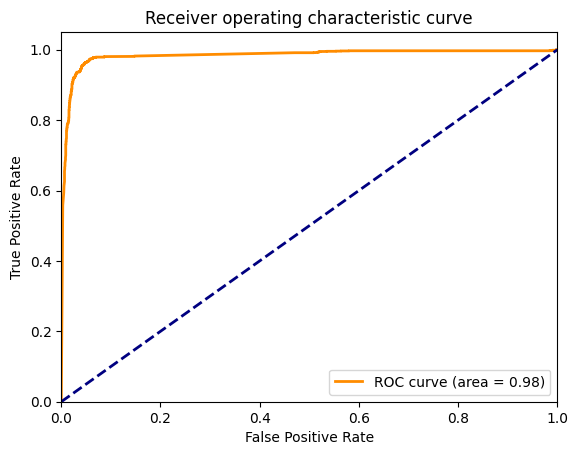

<Figure size 640x480 with 0 Axes>

In [28]:
print("ROC Area Under Curve Score: ", roc_auc_score(ytest, y_pred))

fpr, tpr, _ = roc_curve(ytest[:], y_pred[:])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc.png')

**F1 Score for Multichannel CNN**

In [29]:
y_pred = y_pred.reshape(len(y_pred)).round()

# print(y_pred)
# print(ytest)

f1_bin = f1_score(ytest, y_pred, average='binary')
print("F1 Score for Disclosure Label: ", f1_bin)

f1_none = f1_score(ytest, y_pred, average=None)
print("F1 Score for Disclosure Label: ", f1_none[1])
print("F1 Score for Non-disclosure Label: ", f1_none[0])

f1_weighted = f1_score(ytest, y_pred, average='weighted')
print("F1 Score Weighted: ", f1_weighted)

F1 Score for Disclosure Label:  0.9583846343265205
F1 Score for Disclosure Label:  0.9583846343265205
F1 Score for Non-disclosure Label:  0.957095709570957
F1 Score Weighted:  0.9577401719487388


### Using Multichannel LSTM Network

In [41]:
# fix random seed for reproducibility
np.random.seed(10)

# channel 1
inputs1 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size, 100)(inputs1)
lstm1 = LSTM(100, dropout=0.2)(embedding1)

# channel 2
inputs2 = Input(shape=(max_length,))
embedding2 = Embedding(vocab_size, 100)(inputs2)
lstm2 = LSTM(100, dropout=0.2)(embedding2)

# channel 3
inputs3 = Input(shape=(max_length,))
embedding3 = Embedding(vocab_size, 100)(inputs3)
lstm3 = LSTM(100, dropout=0.2)(embedding3)

# merge
merged = concatenate([lstm1, lstm2, lstm3])

# dropout
# dropped = Dropout(0.2)(merged)

# interpretation
dense = Dense(100, activation='relu')(merged)
dense = Dense(10, activation='relu')(dense)
outputs = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize
print(model.summary())
plot_model(model, show_shapes=True, to_file='multichannel-lstm.png')


model.fit([Xtrain,Xtrain_dep,Xtrain_pos], ytrain, epochs=20, batch_size=50)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 553)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 553)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 553)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 553, 100)     543600      ['input_7[0][0]']                
                                                                                            

In [43]:
# evaluate model on test dataset dataset
loss, acc = model.evaluate([Xtest,Xtest_dep,Xtest_pos], ytest, verbose=1)
print('Test Accuracy: %f' % (acc*100))

125/125 [==============================] - 9s 67ms/step - loss: 0.6931 - accuracy: 0.5000
Test Accuracy: 50.000000


In [32]:
y_pred = model.predict([Xtest,Xtest_dep,Xtest_pos])

125/125 [==============================] - 9s 64ms/step


**ROC Curve for Multichannel LSTM**

ROC Area Under Curve Score:  0.5


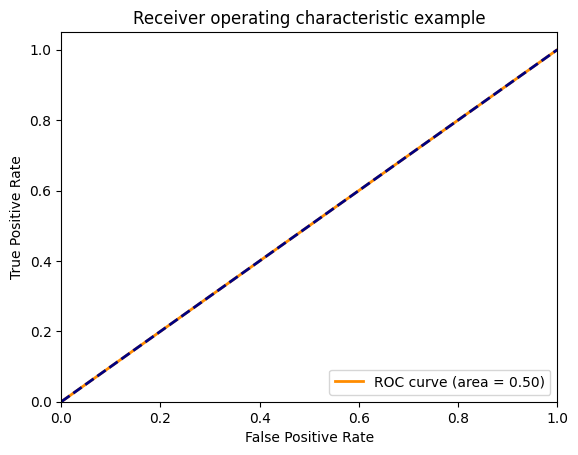

In [33]:
print("ROC Area Under Curve Score: ", roc_auc_score(ytest, y_pred))

fpr, tpr, _ = roc_curve(ytest[:], y_pred[:])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**F1 Score for Multichannel LSTM**

In [34]:
y_pred = y_pred.reshape(len(y_pred)).round()

# print(y_pred)
# print(ytest)

f1_bin = f1_score(ytest, y_pred, average='binary')
print("F1 Score for Disclosure Label: ", f1_bin)

f1_none = f1_score(ytest, y_pred, average=None)
print("F1 Score for Disclosure Label: ", f1_none[1])
print("F1 Score for Non-disclosure Label: ", f1_none[0])

f1_weighted = f1_score(ytest, y_pred, average='weighted')
print("F1 Score Weighted: ", f1_weighted)

F1 Score for Disclosure Label:  0.6666666666666666
F1 Score for Disclosure Label:  0.6666666666666666
F1 Score for Non-disclosure Label:  0.0
F1 Score Weighted:  0.3333333333333333


In [35]:
# val_f1 = f1_score(ytest, y_pred)
# val_recall = recall_score(val_targ, val_predict)
# val_precision = precision_score(val_targ, val_predict)

In [38]:
model.predict([Xtest,Xtest_dep,Xtest_pos])

125/125 [==============================] - 8s 65ms/step


array([[0.5023614],
       [0.5023614],
       [0.5023614],
       ...,
       [0.5023614],
       [0.5023614],
       [0.5023614]], dtype=float32)

In [40]:
[Xtest,Xtest_dep,Xtest_pos]

[array([[  2,   0,   0, ...,   0,   0,   0],
        [  2,   2,   2, ...,   0,   0,   0],
        [  2, 353,  50, ...,   0,   0,   0],
        ...,
        [  2, 175,  43, ...,   0,   0,   0],
        [  2,  89,  68, ...,   0,   0,   0],
        [  2,  55,  60, ...,   0,   0,   0]]),
 array([[  3,   0,   0, ...,   0,   0,   0],
        [ 29,  29,  29, ...,   0,   0,   0],
        [  3,  23, 106, ...,   0,   0,   0],
        ...,
        [  3,  16,  31, ...,   0,   0,   0],
        [  3,  16,  31, ...,   0,   0,   0],
        [ 16,  61,  39, ...,   0,   0,   0]]),
 array([[ 1,  0,  0, ...,  0,  0,  0],
        [27, 27, 27, ...,  0,  0,  0],
        [ 1,  4,  1, ...,  0,  0,  0],
        ...,
        [ 1,  4, 25, ...,  0,  0,  0],
        [ 1,  4, 25, ...,  0,  0,  0],
        [ 1,  4,  4, ...,  0,  0,  0]])]